In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from numba import cuda 

result_path = '../best_models'
if not os.path.exists(result_path):
    os.makedirs(result_path)
sys.path.append('../')

In [2]:
users = pd.read_csv("../data/users_with_topic_sentiment.csv")
users = users.drop('yelping_since', axis = 1)
restaurants = pd.read_csv("../data/restaurants_with_topic_sentiment.csv")
reviews = pd.read_csv("../data/reviews2.csv")
# tips = pd.read_csv("../data/tips2.csv")
reviews_sub = reviews[(reviews['business_id'].isin(restaurants['business_id'])) & \
                      (reviews['user_id'].isin(users['user_id']))].copy()

### Prepare data

In [3]:
user, new_user = train_test_split(users, test_size = 0.1, random_state = 48)
user, new_user = user.copy(), new_user.copy()
reviews_new = reviews[(reviews['user_id'].isin(new_user['user_id'])) & (reviews['business_id'].isin(restaurants['business_id']))].copy()
reviews = reviews[(reviews['user_id'].isin(user['user_id'])) & (reviews['business_id'].isin(restaurants['business_id']))].copy()

print("Number of users in the Training:  ", user.shape[0])
print("Number of New users:  ", new_user.shape[0])

Number of users in the Training:   817
Number of New users:   91


In [4]:
user_label_encoder = LabelEncoder(); user['user_id'] = user_label_encoder.fit_transform(user['user_id'])
new_user_label_encoder = LabelEncoder(); new_user['user_id'] = new_user_label_encoder.fit_transform(new_user['user_id'])
restaurant_label_encoder = LabelEncoder(); restaurants['business_id'] = restaurant_label_encoder.fit_transform(restaurants['business_id'])

reviews['user_id'] = user_label_encoder.transform(reviews['user_id'])
reviews_new['user_id'] = new_user_label_encoder.transform(reviews_new['user_id'])
reviews['business_id'] = restaurant_label_encoder.transform(reviews['business_id'])
reviews_new['business_id'] = restaurant_label_encoder.transform(reviews_new['business_id'])

reviews_score = reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()
reviews_new_score = reviews_new.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()
review_train, review_test = train_test_split(reviews_score, test_size = 0.2, random_state = 48)
review_train, review_val = train_test_split(review_train, test_size = 0.2, random_state = 48)

In [5]:
print("Training: {} users, {} items, {} reviews".format(review_train['user_id'].nunique(), review_train['business_id'].nunique(), review_train.shape[0]))
print("Validation: {} users, {} items, {} reviews".format(review_val['user_id'].nunique(), review_val['business_id'].nunique(), review_val.shape[0]))
print("Testing: {} users, {} items, {} reviews".format(review_test['user_id'].nunique(), review_test['business_id'].nunique(), review_test.shape[0]))

Training: 817 users, 1655 items, 34796 reviews
Validation: 817 users, 1540 items, 8700 reviews
Testing: 817 users, 1580 items, 10874 reviews


In [6]:
num_users, num_new_users, num_items = user.shape[0], new_user.shape[0], restaurants.shape[0]
rating_matrix_sparse_train = csr_matrix((review_train['stars'], (review_train['user_id'], review_train['business_id'])), 
                                        shape = (num_users, num_items))
rating_matrix_sparse_val = csr_matrix((review_val['stars'], (review_val['user_id'], review_val['business_id'])), 
                                        shape = (num_users, num_items))
rating_matrix_sparse_test = csr_matrix((review_test['stars'], (review_test['user_id'], review_test['business_id'])), 
                                        shape = (num_users, num_items))
rating_matrix_sparse_new = csr_matrix((reviews_new_score['stars'], (reviews_new_score['user_id'], reviews_new_score['business_id'])), 
                                        shape = (num_new_users, num_items))

rating_matrix_train = rating_matrix_sparse_train.toarray().astype('float32')
rating_matrix_val = rating_matrix_sparse_val.toarray().astype('float32')
rating_matrix_test = rating_matrix_sparse_test.toarray().astype('float32')
rating_matrix_new = rating_matrix_sparse_new.toarray().astype('float32')

rating_matrix_train_mask = np.where(rating_matrix_train==0, 0, 1)
rating_matrix_val_mask = np.where(rating_matrix_val==0, 0, 1)
rating_matrix_test_mask = np.where(rating_matrix_test==0, 0, 1)
rating_matrix_new_mask = np.where(rating_matrix_new==0, 0, 1)

## With Raw Score

In [7]:
import tensorflow as tf
import torch
from torch.autograd import Variable
from torch.optim import Adam

### Matrix Factorization

#### Method 1: Alternating Least Square

In [8]:
p_lambda = 0.2
hidden_dim = 3

P = np.random.normal(0, 0.01, size=(num_users, hidden_dim))
Q = np.random.normal(0, 0.01, size=(num_items, hidden_dim))

In [9]:
start = time.time()
for epoch in range(30):
    old_P = P.copy()
    old_Q = Q.copy()
    for u in range(num_users):
        P[u, :] = np.linalg.inv(
            Q.T @ np.diag(rating_matrix_train_mask[u, :]) @ Q + \
            p_lambda * np.identity(hidden_dim)
        ) @ Q.T @ np.diag(rating_matrix_train_mask[u, :]) @ rating_matrix_train[u, :]

    for i in range(num_items):
        Q[i, :] = np.linalg.inv(
            P.T @ np.diag(rating_matrix_train_mask[:, i]) @ P + \
            p_lambda * np.identity(hidden_dim)
        ) @ P.T @ np.diag(rating_matrix_train_mask[:, i]) @ rating_matrix_train[:, i]
    print(np.sum((P-old_P)**2), np.sum((Q-old_Q)**2))
end = time.time()
print('Time Elapsed:  ', end-start)

4106.7175041641585 7906.588022144113
4121.214416648843 3971.5145853219356
635.8842747944013 1072.2556121701186
197.46555226856984 286.1026895192336
105.97957209742442 130.02077681592573
76.4895596287583 65.7067367348265
51.23463034275484 34.65113089156445
36.1920284392768 15.962350350130915
28.586010645804084 11.554309355624422
23.47422069516698 9.360003869543537
18.767921617300573 7.452820425215601
14.013615666774381 6.012289543266775
10.204475056785864 4.48161661690288
7.683009995606842 3.373632915268695
6.0914526289491935 2.9022191392648486
5.0679074640134685 2.7725401786310933
4.4305528637384395 2.8685717176021415
4.088549307834997 3.1090506904925195
3.862570917020772 3.1394427673770022
3.530117556903982 2.7671408937977864
3.117313104355887 2.499633734813766
2.76088504016638 2.502241374874187
2.495601538349911 2.5932702027629615
2.2420863689318855 2.148611578963418
1.9034239855369264 1.785476804235405
1.627525783502683 1.776479737918623
1.4878424055492112 1.9913194130088807
1.51215

In [10]:
pred = P@Q.T
sse_train = np.sqrt(np.sum((P@Q.T - rating_matrix_train)**2 * rating_matrix_train_mask) / rating_matrix_sparse_train.nnz)
sse_val = np.sqrt(np.sum((P@Q.T - rating_matrix_val)**2 * rating_matrix_val_mask) / rating_matrix_sparse_val.nnz)
sse_test = np.sqrt(np.sum((P@Q.T - rating_matrix_test)**2 * rating_matrix_test_mask) / rating_matrix_sparse_test.nnz)
print("Training RMSE:  ", sse_train)
print("Validation RMSE:  ", sse_val)
print("Testing RMSE:  ", sse_test)

Training RMSE:   0.673974326732056
Validation RMSE:   1.049204334056031
Testing RMSE:   1.0530248153441173


#### Method 2: Stochastic Gradient Descent

In [8]:
from keras.callbacks import TensorBoard
from skopt import gp_minimize, dump, load
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args

In [106]:
dim_learning_rate = Real(low=1e-5, high=1e-2, prior='log-uniform', name='learning_rate')
dim_hidden = Integer(low=100, high=500, name='hidden_dim')
dim_lambda = Integer(low=1, high=100, name='p_lambda')
dimensions = [dim_learning_rate, dim_hidden, dim_lambda]

@use_named_args(dimensions=dimensions)
def fitness_mf(learning_rate, hidden_dim, p_lambda):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden_dim:', hidden_dim)
    print('norm penalty lambda:', p_lambda)
    
    P_tensor = tf.Variable(tf.random.normal([num_users, hidden_dim], stddev=0.01))
    Q_tensor = tf.Variable(tf.random.normal([num_items, hidden_dim], stddev=0.01))
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    
    num_epochs = 1500
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            sse = (tf.matmul(P_tensor, tf.transpose(Q_tensor)) - rating_matrix_train)**2
            masked_sse = tf.multiply(sse, rating_matrix_train_mask)
            penalty_norm = p_lambda * tf.square(tf.norm(P_tensor)) + tf.square(tf.norm(Q_tensor))
            loss = tf.reduce_sum(masked_sse) + penalty_norm
        gradients = tape.gradient(loss, [P_tensor, Q_tensor])
        optimizer.apply_gradients(zip(gradients, [P_tensor, Q_tensor]))
    validation_sse = (tf.matmul(P_tensor, tf.transpose(Q_tensor)) - rating_matrix_val)**2
    validation_sse_masked = tf.multiply(validation_sse, rating_matrix_val_mask)
    validation_rmse = np.sqrt(np.sum(validation_sse_masked) / rating_matrix_sparse_val.nnz)
    print("Validation RMSE: ", validation_rmse, '\n')
    global best_rmse, best_mf_specs, best_model
    if validation_rmse < best_rmse:
        pkl.dump([P_tensor, Q_tensor], open("../best_models/MF_SGD.pkl", 'wb'))
        best_mf_specs = [learning_rate, hidden_dim, p_lambda]
        best_rmse = validation_rmse
    return validation_rmse

In [107]:
best_rmse = np.inf
best_mf_specs = []
default_parameters = [0.005, 100, 30]
search_result = gp_minimize(func=fitness_mf,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15, # min n_calls=11
                            x0=default_parameters)

learning rate: 5.0e-03
hidden_dim: 100
norm penalty lambda: 30
Validation RMSE:  0.9337296369569474 

learning rate: 2.1e-04
hidden_dim: 450
norm penalty lambda: 21
Validation RMSE:  0.9648857218696729 

learning rate: 7.4e-05
hidden_dim: 396
norm penalty lambda: 81
Validation RMSE:  1.4489561771264026 

learning rate: 6.1e-04
hidden_dim: 321
norm penalty lambda: 69
Validation RMSE:  0.9785312769399416 

learning rate: 2.8e-05
hidden_dim: 349
norm penalty lambda: 8
Validation RMSE:  2.8242711843413955 

learning rate: 6.1e-04
hidden_dim: 299
norm penalty lambda: 3
Validation RMSE:  1.0021316853940352 

learning rate: 9.6e-05
hidden_dim: 214
norm penalty lambda: 2
Validation RMSE:  1.081081445320023 

learning rate: 1.0e-05
hidden_dim: 149
norm penalty lambda: 50
Validation RMSE:  3.914573373724889 

learning rate: 7.5e-04
hidden_dim: 383
norm penalty lambda: 2
Validation RMSE:  1.0125518270225031 

learning rate: 1.6e-03
hidden_dim: 102
norm penalty lambda: 30
Validation RMSE:  0.93775

In [108]:
print("Best specs:  lr: {:.5f}, hidden_dim: {}, norm_penalty: {}".format(*best_mf_specs))
print("Best Validation RMSE:  {:5f}".format(best_rmse))

P_tensor, Q_tensor = pkl.load(open("../best_models/MF_SGD.pkl", 'rb'))
training_sse = (tf.matmul(P_tensor, tf.transpose(Q_tensor)) - rating_matrix_train)**2
training_sse_masked = tf.multiply(training_sse, rating_matrix_train_mask) 
print("Training RMSE:  ", np.sqrt(np.sum(training_sse_masked) / rating_matrix_sparse_train.nnz))

testing_sse = (tf.matmul(P_tensor, tf.transpose(Q_tensor)) - rating_matrix_test)**2
testing_sse_masked = tf.multiply(testing_sse, rating_matrix_test_mask)
print("Testing RMSE:  ", np.sqrt(np.sum(testing_sse_masked) / rating_matrix_sparse_test.nnz))

Best specs:  lr: 0.00500, hidden_dim: 100, norm_penalty: 30
Best Validation RMSE:  0.933730
Training RMSE:   0.5748495069881868
Testing RMSE:   0.9378946850206065


### AutoEncoder

In [10]:
from utils.AutoRec import AutoRec

In [11]:
@use_named_args(dimensions=dimensions)
def fitness_auto_raw(learning_rate, hidden_dim, p_lambda):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden_dim:', hidden_dim)
    print('norm penalty lambda:', p_lambda)
    
    global user_param_ordered_dict, best_rmse, best_auto_raw_specs
    
    user_param_ordered_dict['learning_rate'] = learning_rate
    user_param_ordered_dict['hidden_dim'] = hidden_dim
    user_param_ordered_dict['p_lambda'] = p_lambda

    uAuto = AutoRec()
    uAuto.train(**user_param_ordered_dict)
    validation_rmse = uAuto.test(user_param_ordered_dict['val_X'], 
                                 user_param_ordered_dict['val_y'],
                                 user_param_ordered_dict['val_y_mask'])
    print("Validation RMSE: ", validation_rmse, '\n')
    if validation_rmse < best_rmse:
        pkl.dump(uAuto, open('../best_models/auto_raw.pkl', 'wb'))
        best_auto_raw_specs = [learning_rate, hidden_dim, p_lambda]
        best_rmse = validation_rmse
    return validation_rmse

In [12]:
user_param_ordered_dict = OrderedDict({
    "train_X": rating_matrix_train,
    'train_y': rating_matrix_train,
    'train_y_mask': rating_matrix_train_mask,
    'val_X': rating_matrix_val, 
    'val_y': rating_matrix_val, 
    'val_y_mask': rating_matrix_val_mask,
    'hidden_dim': None,
    'p_lambda': None, 
    'learning_rate': None, 
    'num_epochs': 2000,
    'dropout': 0.95,
    'verbose': False
})

In [18]:
best_rmse = np.inf
best_auto_raw_specs = []
default_parameters = [0.005, 100, 30]
search_result = gp_minimize(func=fitness_auto_raw,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15, # min n_calls=11
                            x0=default_parameters)

learning rate: 5.0e-03
hidden_dim: 100
norm penalty lambda: 30
Validation RMSE:  0.8857235565177219 

learning rate: 6.6e-05
hidden_dim: 180
norm penalty lambda: 20
Validation RMSE:  1.5716137939662713 

learning rate: 7.6e-05
hidden_dim: 469
norm penalty lambda: 92
Validation RMSE:  1.2319495941159804 

learning rate: 1.3e-05
hidden_dim: 140
norm penalty lambda: 10
Validation RMSE:  2.3718052658490314 

learning rate: 1.3e-04
hidden_dim: 115
norm penalty lambda: 29
Validation RMSE:  1.646132074953178 

learning rate: 2.2e-03
hidden_dim: 499
norm penalty lambda: 5
Validation RMSE:  1.095378098593956 

learning rate: 8.3e-04
hidden_dim: 306
norm penalty lambda: 23
Validation RMSE:  1.0138002506785357 

learning rate: 6.1e-03
hidden_dim: 159
norm penalty lambda: 37
Validation RMSE:  0.8856131670053669 

learning rate: 1.6e-04
hidden_dim: 261
norm penalty lambda: 19
Validation RMSE:  1.4684707181282164 

learning rate: 3.2e-03
hidden_dim: 310
norm penalty lambda: 24
Validation RMSE:  0.89

In [19]:
print("Best specs:  lr: {:.5f}, hidden_dim: {}, norm_penalty: {}".format(*best_auto_raw_specs))
print("Best Validation RMSE:  {:5f}".format(best_rmse))

uauto = pkl.load(open("../best_models/auto_raw.pkl", 'rb'))
train_rmse = uauto.test(rating_matrix_train, rating_matrix_train, rating_matrix_train_mask)
print("Training RMSE:  ", train_rmse)
test_rmse = uauto.test(rating_matrix_test, rating_matrix_test, rating_matrix_test_mask)
print("Testing RMSE:  ", test_rmse)

Best specs:  lr: 0.00463, hidden_dim: 265, norm_penalty: 100
Best Validation RMSE:  0.884649
Training RMSE:   0.8283538462113494
Testing RMSE:   0.8979563861735103


## With Grouping Information (Cold Start: User)
### Add in user/item covaraites
### Method1: KMeans

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [14]:
users.head()

,user_id,review_count,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,...,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1jXmzuIFKxTnEnR0pxO0Hg,299,381,106,121,1,23,3.43,17,8,...,0.042572,0.037779,0.166696,0.189951,0.044507,0.065257,0.050626,0.111216,0.067327,0.210800
1,CQUDh80m48xnzUkx-X5NAw,4205,21059,8906,14640,1,575,3.90,679,149,...,0.025114,0.034576,0.058662,0.288541,0.084098,0.067602,0.122377,0.042213,0.110000,0.148914
2,e_YQl5LBR7Gdrp_1vdj1yQ,671,1509,646,870,1,57,3.90,113,14,...,0.064300,0.037523,0.030578,0.354856,0.064716,0.048552,0.069523,0.123337,0.088852,0.107791
3,D8TvYz5Cy5-4V-LuD5nXvQ,478,2115,1544,1614,0,61,3.80,276,18,...,0.046223,0.162164,0.041739,0.257255,0.026008,0.040335,0.143995,0.029820,0.066427,0.166266
4,Vlab9b73R5qPLIv6tE4DJA,955,3140,2130,1800,1,90,3.57,138,21,...,0.029600,0.104688,0.039396,0.352079,0.015639,0.065088,0.091002,0.034000,0.061560,0.193788


In [15]:
## Standardize users
user_reduced = user.copy()
user_scaler = StandardScaler()
compliment_columns = [c for c in user.columns if 'compliment_' in c]
receive_columns = ['useful', 'funny', 'cool']
other_columns = ['review_count', 'fans']
std_columns = compliment_columns + receive_columns + other_columns
user_reduced[std_columns] = user_scaler.fit_transform(user_reduced[std_columns])

In [16]:
## Combine compliments and received compliments columns using PCA

compliment_pca = PCA(n_components = 5)
user_reduced['pca_compliment'] = compliment_pca.fit_transform(user_reduced[compliment_columns])[:,0]
user_reduced = user_reduced.drop(compliment_columns, axis = 1)
print("Compliment PCA:  ", compliment_pca.explained_variance_ratio_)

receive_pca = PCA(n_components = 2)
user_reduced['pca_votes'] = receive_pca.fit_transform(user_reduced[receive_columns])[:,0]
print("Votes PCA:  ",receive_pca.explained_variance_ratio_)
user_reduced = user_reduced.drop(receive_columns, axis = 1)

Compliment PCA:   [0.96585643 0.01509357 0.00881778 0.00522637 0.00251069]
Votes PCA:   [0.99086698 0.00750579]


In [17]:
user_reduced.head()

,user_id,review_count,elite,fans,average_stars,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pca_compliment,pca_votes
351,261,0.483180,1,0.042877,3.58,0.051214,0.050869,0.042723,0.101007,0.120631,0.056818,0.047377,0.084398,0.172520,0.263376,-0.189542,-0.213430
889,791,-0.218976,1,-0.263111,3.95,0.096814,0.079692,0.046358,0.148451,0.111781,0.089968,0.109744,0.086862,0.140961,0.080314,-0.346564,-0.224788
786,181,0.399010,1,0.037942,3.96,0.041350,0.099356,0.212316,0.150962,0.115749,0.067314,0.078539,0.131703,0.043590,0.048724,-0.356963,-0.082359
270,592,-0.117086,1,-0.134793,4.04,0.062158,0.066621,0.077139,0.158898,0.072171,0.042814,0.088181,0.088552,0.116247,0.216684,-0.248215,-0.284173
624,397,-0.358522,1,-0.312464,4.06,0.065094,0.076134,0.230560,0.116523,0.050362,0.125912,0.064129,0.077892,0.061008,0.112915,-0.405147,-0.361500


In [18]:
# Preprocess new users using the trained standardized and pca
new_user_reduced = new_user.copy()
new_user_reduced[std_columns] = user_scaler.transform(new_user_reduced[std_columns])
new_user_reduced['pca_compliment'] = compliment_pca.transform(new_user_reduced[compliment_columns])[:,0]
new_user_reduced = new_user_reduced.drop(compliment_columns, axis = 1)
new_user_reduced['pca_votes'] = receive_pca.fit_transform(new_user_reduced[receive_columns])[:,0]
new_user_reduced = new_user_reduced.drop(receive_columns, axis = 1)

In [19]:
## Remove some extreme cases for more stable kmeans clustering
remove_extreme = lambda df, col, perc: df.loc[df[col] < np.quantile(df[col], 0.95),]
user_reduced_temp = user_reduced.copy()
user_reduced_temp = remove_extreme(user_reduced_temp, 'pca_compliment', 0.95)
user_reduced_temp = remove_extreme(user_reduced_temp, 'pca_votes', 0.95)
user_reduced_temp = remove_extreme(user_reduced_temp, 'fans', 0.95)
user_reduced_temp = remove_extreme(user_reduced_temp, 'review_count', 0.95)
print(user_reduced_temp.shape)

(665, 17)


In [20]:
cluster_columns = ['review_count', 'elite', 'fans', 'average_stars', 'pca_compliment', 'pca_votes']
kmeans = KMeans(n_clusters=6, random_state = 48)
print("Labels on extreme free users:  ", Counter(kmeans.fit_predict(user_reduced_temp[cluster_columns])))
print("Labels on all existing users:  ", Counter(kmeans.predict(user_reduced[cluster_columns])))
print("Labels on new users:  ", Counter(kmeans.predict(new_user_reduced[cluster_columns])))

Labels on extreme free users:   Counter({2: 206, 1: 133, 3: 115, 5: 107, 0: 55, 4: 49})
Labels on all existing users:   Counter({2: 206, 0: 162, 3: 155, 1: 134, 5: 107, 4: 53})
Labels on new users:   Counter({3: 21, 2: 20, 0: 20, 5: 11, 1: 11, 4: 8})


In [21]:
user_reduced_temp['kmeans_labels'] = kmeans.predict(user_reduced_temp[cluster_columns])
user_reduced['kmeans_labels'] = kmeans.predict(user_reduced[cluster_columns])
new_user_reduced['kmeans_labels'] = kmeans.predict(new_user_reduced[cluster_columns])

In [22]:
user_group_results = pd.concat([user_reduced.groupby('kmeans_labels').mean().reset_index(), 
                           user_reduced.groupby('kmeans_labels')['user_id'].count().to_frame('count')], axis=1)
user_group_results.columns = ['label'] + list(user_group_results.columns)[1:]
user_group_results

,label,user_id,review_count,elite,fans,average_stars,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pca_compliment,pca_votes,count
0,0,450.722222,0.609196,0.993827,0.930346,3.878395,0.056892,0.064978,0.062707,0.261407,0.045808,0.077514,0.081586,0.103460,0.084464,0.151397,1.429910,1.235307,162
1,1,401.813433,-0.344975,1.000000,-0.263921,4.179104,0.059587,0.065548,0.135510,0.180455,0.059121,0.092227,0.082443,0.102775,0.094935,0.112825,-0.375546,-0.333703,134
2,2,388.116505,-0.368349,1.000000,-0.286278,3.804466,0.060517,0.074581,0.108073,0.200070,0.060118,0.068210,0.085229,0.101800,0.092543,0.134738,-0.366792,-0.345144,206
3,3,390.832258,0.460208,1.000000,-0.074519,3.784774,0.064006,0.073642,0.091422,0.222401,0.052082,0.075982,0.082012,0.095793,0.090649,0.137976,-0.303010,-0.201971,155
4,4,430.113208,-0.281101,0.000000,-0.328201,3.731132,0.062695,0.092122,0.125245,0.193523,0.057521,0.071926,0.093858,0.092066,0.086908,0.103073,-0.397347,-0.360214,53
5,5,403.261682,-0.308570,1.000000,-0.256377,3.413458,0.057773,0.080294,0.078603,0.204323,0.060684,0.062418,0.076465,0.101796,0.103349,0.159830,-0.352683,-0.316887,107


#### User Group Viz via PCA

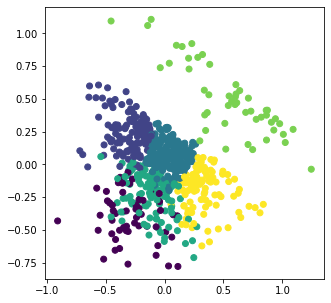

In [23]:
pca_visualize = PCA(n_components = 2)
coords = pca_visualize.fit_transform(user_reduced_temp[cluster_columns])
plt.figure(figsize = (5, 5))
plt.scatter(coords[:, 0], coords[:, 1], c = user_reduced_temp['kmeans_labels'])
plt.show()

#### User Group Viz via t-SNE

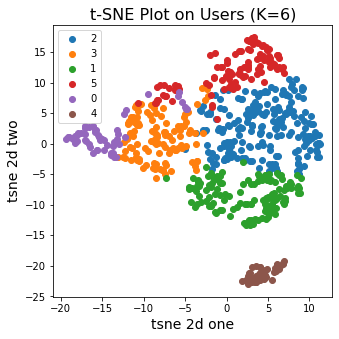

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=256)
tsne_pca_results = tsne.fit_transform(user_reduced_temp[cluster_columns])
temp = user_reduced_temp.reset_index(drop=True)
plt.figure(figsize = (5, 5))
for c in temp['kmeans_labels'].unique():
    idx = temp[temp['kmeans_labels']==c].index
    plt.scatter(tsne_pca_results[idx, 0], tsne_pca_results[idx, 1], 
                label=c)
plt.title('t-SNE Plot on Users (K=6)', fontsize=16)
plt.xlabel('tsne 2d one', fontsize=14)
plt.ylabel('tsne 2d two', fontsize=14)
plt.legend()
plt.savefig('../plots/tsne_users.png')
plt.show()

#### Fill in Rating for new users

In [25]:
def fill_in_group_information(rating_matrix, user_reduced, new_user_reduced, mode = 'uniform', sigma=1, C=1):
    num_new_user, num_item = new_user_reduced.shape[0], rating_matrix.shape[1]
    filled_rating_matrix = np.zeros(shape = (num_new_user, num_item))
    for i in range(num_new_user):
        new_user_group = new_user_reduced.loc[new_user_reduced['user_id'] == i, 'kmeans_labels'].unique()
        obs_user = user_reduced.loc[user_reduced['kmeans_labels'] == new_user_group[0], ]
        obs_ratings = rating_matrix[obs_user['user_id'], :]
        if mode == 'uniform':
            obs_ratings_sum = obs_ratings.sum(0)
            obs_ratings_size = (obs_ratings != 0).sum(0)
            filled_rating_matrix[i] = np.divide(obs_ratings_sum, obs_ratings_size, 
                                                out=np.zeros_like(obs_ratings_sum), where=obs_ratings_size!=0)
        if mode == 'weighted':
            new_user_x = new_user_reduced.loc[new_user_reduced['user_id'] == i].drop(['user_id', 'kmeans_labels'], axis = 1)
            obs_user_x = obs_user.drop(['user_id', 'kmeans_labels'], axis = 1)
            weights = np.exp(-np.sum((obs_user_x.to_numpy() - new_user_x.to_numpy())**2, axis=1) / (2 * 0.1**2))
            weights = weights.reshape(obs_user.shape[0], 1)
            obs_ratings_weighted_sum = (obs_ratings * weights).sum(0)
            obs_ratings_mask = np.abs(np.sign(obs_ratings))
            obs_ratings_weighted_mask = (obs_ratings_mask * weights).sum(0)
            filled_rating_matrix[i] = np.divide(obs_ratings_weighted_sum, obs_ratings_weighted_mask, 
                                    out=np.zeros_like(obs_ratings_weighted_sum), where=obs_ratings_weighted_mask!=0)
    np.random.seed(48)
    random_choice = np.random.choice(np.arange(2), size=filled_rating_matrix.shape, p=[0.9, 0.1])
    filled_rating_matrix = filled_rating_matrix * random_choice
    return filled_rating_matrix.astype('float32')

In [26]:
new_user_filled = fill_in_group_information(rating_matrix_train, user_reduced_temp, new_user_reduced,
                                            mode='weighted', sigma=1)

In [34]:
print("Filled new user RMSE:  ", uauto.test(new_user_filled, rating_matrix_new, rating_matrix_new_mask))

Filled new user RMSE:   0.9161166026774089


### Method 2: Semi-AutoEncoder

In [27]:
user_covariates = user_reduced.sort_values('user_id').drop(['user_id', 'kmeans_labels'], axis = 1).astype('float32')
rating_matrix_train_user = np.concatenate([rating_matrix_train, user_covariates], axis = 1).astype('float32')
rating_matrix_val_user = np.concatenate([rating_matrix_val, user_covariates], axis = 1).astype('float32')
rating_matrix_test_user = np.concatenate([rating_matrix_test, user_covariates], axis = 1).astype('float32')

new_user_covariates = new_user_reduced.sort_values('user_id').drop(['user_id', 'kmeans_labels'], axis = 1).astype('float32')
rating_matrix_new_user = np.concatenate([new_user_filled, new_user_covariates], axis=1).astype('float32')

In [28]:
@use_named_args(dimensions=dimensions)
def fitness_auto_semi_user(learning_rate, hidden_dim, p_lambda):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden_dim:', hidden_dim)
    print('norm penalty lambda:', p_lambda)
    
    global semi_user_param_ordered_dict, best_rmse, best_auto_semi_specs
    
    semi_user_param_ordered_dict['learning_rate'] = learning_rate
    semi_user_param_ordered_dict['hidden_dim'] = hidden_dim
    semi_user_param_ordered_dict['p_lambda'] = p_lambda

    uAuto = AutoRec()
    uAuto.train(**semi_user_param_ordered_dict)
    validation_rmse = uAuto.test(semi_user_param_ordered_dict['val_X'], 
                                 semi_user_param_ordered_dict['val_y'],
                                 semi_user_param_ordered_dict['val_y_mask'])
    print("Validation RMSE: ", validation_rmse, '\n')
    if validation_rmse < best_rmse:
        pkl.dump(uAuto, open('../best_models/uauto_semi_text.pkl', 'wb'))
        best_auto_semi_specs = [learning_rate, hidden_dim, p_lambda]
        best_rmse = validation_rmse
    return validation_rmse

In [29]:
semi_user_param_ordered_dict = user_param_ordered_dict.copy()
semi_user_param_ordered_dict['train_X'] = rating_matrix_train_user
semi_user_param_ordered_dict['val_X'] = rating_matrix_val_user

In [36]:
best_rmse = np.inf
best_auto_semi_specs = []
default_parameters = [0.005, 100, 30]
search_result = gp_minimize(func=fitness_auto_semi_user,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15, # min n_calls=11
                            x0=default_parameters)

learning rate: 5.0e-03
hidden_dim: 100
norm penalty lambda: 30
Validation RMSE:  0.8839987484530298 

learning rate: 1.9e-05
hidden_dim: 328
norm penalty lambda: 27
Validation RMSE:  1.4811876320591333 

learning rate: 6.5e-05
hidden_dim: 179
norm penalty lambda: 38
Validation RMSE:  1.5012858921939467 

learning rate: 1.2e-04
hidden_dim: 306
norm penalty lambda: 66
Validation RMSE:  1.2633745246266346 

learning rate: 4.6e-03
hidden_dim: 158
norm penalty lambda: 44
Validation RMSE:  0.8840831214354452 

learning rate: 1.5e-04
hidden_dim: 404
norm penalty lambda: 10
Validation RMSE:  1.119677303034689 

learning rate: 2.4e-04
hidden_dim: 196
norm penalty lambda: 5
Validation RMSE:  1.3613095215658146 

learning rate: 4.5e-04
hidden_dim: 232
norm penalty lambda: 32
Validation RMSE:  1.069233911502616 

learning rate: 8.5e-05
hidden_dim: 209
norm penalty lambda: 37
Validation RMSE:  1.4531295189028735 

learning rate: 2.4e-03
hidden_dim: 113
norm penalty lambda: 29
Validation RMSE:  0.89

In [38]:
print("Best specs:  lr: {:.5f}, hidden_dim: {}, norm_penalty: {}".format(*best_auto_semi_specs))
print("Best Validation RMSE:  {:5f}".format(best_rmse))

uauto = pkl.load(open("../best_models/uauto_semi_text.pkl", 'rb'))
train_rmse = uauto.test(rating_matrix_train_user, rating_matrix_train, rating_matrix_train_mask)
print("Training RMSE:  ", train_rmse)
test_rmse = uauto.test(rating_matrix_test_user, rating_matrix_test, rating_matrix_test_mask)
print("Testing RMSE:  ", test_rmse)
new_user_rmse = uauto.test(rating_matrix_new_user, rating_matrix_new, rating_matrix_new_mask)
print("New User RMSE:  ", new_user_rmse)

Best specs:  lr: 0.00500, hidden_dim: 100, norm_penalty: 30
Best Validation RMSE:  0.883999
Training RMSE:   0.8055527821333938
Testing RMSE:   0.8978078049058404
New User RMSE:   0.9164089163990125


In [40]:
# semi_uAuto = AutoRec()
# semi_uAuto.train(**semi_user_param_ordered_dict)
# print("Test RMSE:  ", semi_uAuto.test(rating_matrix_test_user, rating_matrix_test, rating_matrix_test_mask))
# print("New User RMSE:  ", semi_uAuto.test(rating_matrix_new_user, rating_matrix_new, rating_matrix_new_mask))

### Dual AutoEncoder (Cold Start: Users & Items)

In [39]:
from utils.DualAutoRec import DualAutoRec

In [40]:
drop_columns = ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'attributes', 'categories', 'hours']
restaurant_covariates = restaurants.sort_values('business_id').drop(drop_columns, axis = 1).astype('float32').copy()
restaurant_covariates = restaurant_covariates.fillna(0)
std_columns = ['latitude', 'longitude', 'stars', 'review_count']
item_scaler = StandardScaler()
restaurant_covariates[std_columns] = item_scaler.fit_transform(restaurant_covariates[std_columns]).astype('float32')
rating_matrix_train_item = np.concatenate([rating_matrix_train.T, restaurant_covariates], axis = 1).astype('float32')
rating_matrix_val_item = np.concatenate([rating_matrix_val.T, restaurant_covariates], axis = 1).astype('float32')
rating_matrix_test_item = np.concatenate([rating_matrix_test.T, restaurant_covariates], axis = 1).astype('float32')

In [41]:
semi_item_param_ordered_dict = OrderedDict({
    "train_X": rating_matrix_train_item,
    'train_y': rating_matrix_train.T,
    'train_y_mask': rating_matrix_train_mask.T,
    'val_X': rating_matrix_val_item, 
    'val_y': rating_matrix_val.T, 
    'val_y_mask': rating_matrix_val_mask.T,
    'hidden_dim': 300,
    'p_lambda': 30, 
    'learning_rate': 1e-3, 
    'num_epochs': 2000,
    'dropout': 0.95,
    'verbose': False
})

### Method 1: Integrate Loss

In [43]:
dim_learning_rate = Real(low=1e-5, high=1e-2, prior='log-uniform', name='learning_rate')
dim_hidden = Integer(low=100, high=500, name='hidden_dim')
dim_hidden_user = Integer(low=100, high=500, name='hidden_dim_user')
dim_hidden_item = Integer(low=100, high=500, name='hidden_dim_item')
dim_lambda = Integer(low=1, high=100, name='p_lambda')
dimensions = [dim_learning_rate, dim_hidden, dim_hidden_user, dim_hidden_item, dim_lambda]

@use_named_args(dimensions=dimensions)
def fitness_dual_semi(learning_rate, hidden_dim, hidden_dim_user, hidden_dim_item, p_lambda):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden_dim:', hidden_dim, hidden_dim_user, hidden_dim_item)
    print('norm penalty lambda:', p_lambda)
    
    global semi_user_param_ordered_dict, semi_item_param_ordered_dict, best_rmse, best_dual_semi_specs
    semi_user_param_ordered_dict['hidden_dim'] = hidden_dim_user
    semi_item_param_ordered_dict['hidden_dim'] = hidden_dim_item
    dual = DualAutoRec(mode='DUAL')
    dual.train(rating_matrix_train, semi_user_param_ordered_dict, semi_item_param_ordered_dict,
              hidden_dim=hidden_dim, p_lambda=p_lambda, learning_rate=learning_rate, num_epochs=3000, 
               verbose=False)
                                   
    validation_rmse = dual.test(semi_user_param_ordered_dict['val_X'], 
                                semi_item_param_ordered_dict['val_X'],
                                semi_user_param_ordered_dict['val_y'])[0]
    print("Validation RMSE: ", validation_rmse, '\n')
    if validation_rmse < best_rmse:
        pkl.dump(dual, open('../best_models/dual_semi_text.pkl', 'wb'))
        best_dual_semi_specs = [learning_rate, hidden_dim, hidden_dim_user, hidden_dim_item, p_lambda]
        best_rmse = validation_rmse
    return validation_rmse

In [44]:
best_rmse = np.inf
best_auto_semi_specs = []
default_parameters = [0.005, 100, 100, 100, 30]
search_result = gp_minimize(func=fitness_dual_semi,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15, # min n_calls=11
                            x0=default_parameters)

learning rate: 5.0e-03
hidden_dim: 100 100 100
norm penalty lambda: 30
Validation RMSE:  0.9142581484543008 

learning rate: 2.2e-03
hidden_dim: 403 123 201
norm penalty lambda: 63
Validation RMSE:  0.8993719996275625 

learning rate: 6.4e-03
hidden_dim: 302 298 261
norm penalty lambda: 75
Validation RMSE:  0.9474387867190901 

learning rate: 2.1e-04
hidden_dim: 292 366 448
norm penalty lambda: 54
Validation RMSE:  0.9028749579289329 

learning rate: 6.0e-04
hidden_dim: 421 189 360
norm penalty lambda: 25
Validation RMSE:  0.898741593339498 

learning rate: 9.8e-04
hidden_dim: 241 327 261
norm penalty lambda: 77
Validation RMSE:  0.9082436330340219 

learning rate: 2.0e-05
hidden_dim: 332 338 492
norm penalty lambda: 11
Validation RMSE:  0.9094274274396248 

learning rate: 3.9e-04
hidden_dim: 321 307 348
norm penalty lambda: 61
Validation RMSE:  0.9102483758749839 

learning rate: 1.6e-05
hidden_dim: 203 306 144
norm penalty lambda: 83
Validation RMSE:  1.0249496785551973 

learning ra

In [60]:
print("Best specs:  lr: {:.5f}, hidden_dim: {}, {}, {}, norm_penalty: {}".format(*best_dual_semi_specs))
print("Best Validation RMSE:  {:5f}".format(best_rmse))

dual = pkl.load(open("../best_models/dual_semi_text.pkl", 'rb'))
train_rmse = dual.test(rating_matrix_train_user, rating_matrix_train_item, rating_matrix_train)[0]
print("Training RMSE:  ", train_rmse)
test_rmse = dual.test(rating_matrix_test_user, rating_matrix_test_item, rating_matrix_test)[0]
print("Testing RMSE:  ", test_rmse)
new_user_rmse = dual.test(rating_matrix_new_user, rating_matrix_train_item, rating_matrix_new)[0]
print("New User RMSE:  ", new_user_rmse)

Best specs:  lr: 0.00207, hidden_dim: 481, 122, 494, norm_penalty: 12
Best Validation RMSE:    inf
Training RMSE:   0.8493826904059931
Testing RMSE:   0.9046061662817921
New RMSE:   0.8864512829451293


### Method 2: User & Item Encoder + Fine-tuning

In [61]:
dimensions = [dim_learning_rate, dim_hidden_item, dim_lambda]

@use_named_args(dimensions=dimensions)
def fitness_auto_semi_item(learning_rate, hidden_dim_item, p_lambda):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden_dim:', hidden_dim_item)
    print('norm penalty lambda:', p_lambda)
    
    global semi_item_param_ordered_dict, best_rmse, best_auto_semi_specs
    
    semi_item_param_ordered_dict['learning_rate'] = learning_rate
    semi_item_param_ordered_dict['hidden_dim'] = hidden_dim_item
    semi_item_param_ordered_dict['p_lambda'] = p_lambda

    iAuto = AutoRec()
    iAuto.train(**semi_item_param_ordered_dict)
    validation_rmse = iAuto.test(semi_item_param_ordered_dict['val_X'], 
                                 semi_item_param_ordered_dict['val_y'],
                                 semi_item_param_ordered_dict['val_y_mask'])
    print("Validation RMSE: ", validation_rmse, '\n')
    if validation_rmse < best_rmse:
        pkl.dump(iAuto, open('../best_models/iauto_semi.pkl', 'wb'))
        best_auto_semi_specs = [learning_rate, hidden_dim_item, p_lambda]
        best_rmse = validation_rmse
    return validation_rmse

In [62]:
best_rmse = np.inf
best_auto_semi_specs = []
default_parameters = [0.005, 100, 30]
search_result = gp_minimize(func=fitness_auto_semi_item,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15, # min n_calls=11
                            x0=default_parameters)

learning rate: 5.0e-03
hidden_dim: 100
norm penalty lambda: 30
Validation RMSE:  0.8721930037416387 

learning rate: 1.2e-03
hidden_dim: 254
norm penalty lambda: 47
Validation RMSE:  0.915280880079801 

learning rate: 5.3e-04
hidden_dim: 185
norm penalty lambda: 3
Validation RMSE:  1.1450635475890591 

learning rate: 4.0e-03
hidden_dim: 371
norm penalty lambda: 67
Validation RMSE:  0.8713437696904983 

learning rate: 1.6e-05
hidden_dim: 230
norm penalty lambda: 45
Validation RMSE:  1.5733102337412121 

learning rate: 1.5e-03
hidden_dim: 294
norm penalty lambda: 24
Validation RMSE:  0.8744557459142801 

learning rate: 5.4e-04
hidden_dim: 191
norm penalty lambda: 56
Validation RMSE:  1.0680457659957716 

learning rate: 2.0e-03
hidden_dim: 313
norm penalty lambda: 70
Validation RMSE:  0.8738920145264865 

learning rate: 3.0e-04
hidden_dim: 273
norm penalty lambda: 65
Validation RMSE:  1.0533440650938282 

learning rate: 9.7e-04
hidden_dim: 123
norm penalty lambda: 10
Validation RMSE:  1.0

In [63]:
print("Best specs:  lr: {:.5f}, hidden_dim: {}, norm_penalty: {}".format(*best_auto_semi_specs))
print("Best Validation RMSE:  {:5f}".format(best_rmse))

iauto = pkl.load(open("../best_models/iauto_semi.pkl", 'rb'))
train_rmse = iauto.test(rating_matrix_train_item, rating_matrix_train.T, rating_matrix_train_mask.T)
print("Training RMSE:  ", train_rmse)
test_rmse = iauto.test(rating_matrix_test_item, rating_matrix_test.T, rating_matrix_test_mask.T)
print("Testing RMSE:  ", test_rmse)

Best specs:  lr: 0.00335, hidden_dim: 160, norm_penalty: 19
Best Validation RMSE:  0.858155
Training RMSE:   0.8029243188689089
Testing RMSE:   0.8644475920365323


In [64]:
dimensions = [dim_learning_rate, dim_hidden, dim_lambda]

@use_named_args(dimensions=dimensions)
def fitness_dual_sep(learning_rate, hidden_dim, p_lambda):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden_dim:', dim_hidden)
    print('norm penalty lambda:', p_lambda)
    
    global best_rmse, best_dual_sep_sepcs
    
    dual = DualAutoRec(mode='DUAL-SEP')
    dual.uAuto = uauto
    dual.iAuto = iauto
    dual.train(rating_matrix_train, 
               semi_user_param_ordered_dict, 
               semi_item_param_ordered_dict, 
               retrain_user=False, 
               retrain_item=False,
               hidden_dim = hidden_dim, 
               learning_rate = learning_rate,
               p_lambda = p_lambda, 
               num_epochs=3000,
              verbose = False)

    validation_rmse = dual.test(semi_user_param_ordered_dict['val_X'], 
                                 semi_item_param_ordered_dict['val_X'],
                                 rating_matrix_val)[0]
    print("Validation RMSE: ", validation_rmse, '\n')
    if validation_rmse < best_rmse:
        pkl.dump(dual, open('../best_models/dual_sep.pkl', 'wb'))
        best_dual_sep_sepcs = [learning_rate, hidden_dim, p_lambda]
        best_rmse = validation_rmse
    return validation_rmse

In [65]:
best_rmse = np.inf
best_dual_sep_sepcs = []
default_parameters = [0.005, 100, 30]
search_result = gp_minimize(func=fitness_dual_sep,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15, # min n_calls=11
                            x0=default_parameters)

learning rate: 5.0e-03
hidden_dim: Integer(low=100, high=500, prior='uniform', transform='identity')
norm penalty lambda: 30
Validation RMSE:  0.8978101414096188 

learning rate: 8.0e-04
hidden_dim: Integer(low=100, high=500, prior='uniform', transform='identity')
norm penalty lambda: 97
Validation RMSE:  0.9022740890598561 

learning rate: 2.4e-03
hidden_dim: Integer(low=100, high=500, prior='uniform', transform='identity')
norm penalty lambda: 4
Validation RMSE:  0.8903712584700175 

learning rate: 1.6e-05
hidden_dim: Integer(low=100, high=500, prior='uniform', transform='identity')
norm penalty lambda: 25
Validation RMSE:  0.904879872421158 

learning rate: 8.3e-03
hidden_dim: Integer(low=100, high=500, prior='uniform', transform='identity')
norm penalty lambda: 71
Validation RMSE:  0.8898125957972093 

learning rate: 3.4e-04
hidden_dim: Integer(low=100, high=500, prior='uniform', transform='identity')
norm penalty lambda: 56
Validation RMSE:  0.8857659153156175 

learning rate: 2.2

In [66]:
print("Best specs:  lr: {:.5f}, hidden_dim: {}, norm_penalty: {}".format(*best_dual_sep_sepcs))
print("Best Validation RMSE:  {:5f}".format(best_rmse))

dual = pkl.load(open("../best_models/dual_sep.pkl", 'rb'))
train_rmse = dual.test(rating_matrix_train_user, rating_matrix_train_item, rating_matrix_train)[0]
print("Training RMSE:  ", train_rmse)
test_rmse = dual.test(rating_matrix_test_user, rating_matrix_val_item, rating_matrix_test)[0]
print("Testing RMSE:  ", test_rmse)
new_user_rmse = dual.test(rating_matrix_new_user, rating_matrix_train_item, rating_matrix_new)[0]
print("New RMSE:  ", new_user_rmse)

Best specs:  lr: 0.00034, hidden_dim: 418, norm_penalty: 56
Best Validation RMSE:  0.885766
Training RMSE:   0.8285159165410197
Testing RMSE:   0.8976955649873299
New RMSE:   0.894095410022285


In [47]:
review_train

,user_id,business_id,stars
3589,52,629,4.0
26738,396,1526,4.0
35568,536,1505,2.0
39259,588,1261,4.0
41709,620,1317,2.0
...,...,...,...
21468,314,850,1.0
39758,596,1515,4.0
15776,226,655,5.0
33174,495,1278,3.0


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,positive
0,1264,Legal Sea Foods,1 Harborside Dr,Boston,MA,02128,42.363442,-71.025781,3.5,856,...,0.035265,0.141466,0.150173,0.307001,0.034162,0.060086,0.054494,0.009610,0.174091,0.725953
1,930,Sapporo Ramen,1815 Massachusetts Ave,Cambridge,MA,02140,42.387212,-71.118532,3.5,635,...,0.023923,0.042671,0.111032,0.519666,0.013159,0.007964,0.006669,0.077571,0.167961,0.743423
2,1071,Papi's Cuban & Caribbean Grill,216 Ponce De Leon Ave NE,Atlanta,GA,30308,33.772758,-84.380375,4.0,1001,...,0.281930,0.207915,0.103038,0.005209,0.020214,0.126170,0.031442,0.066024,0.125674,0.766446
3,1593,Schmidt's Sausage Haus,240 E Kossuth St,Columbus,OH,43206,39.946268,-82.991044,4.0,1354,...,0.017671,0.190631,0.168448,0.005582,0.083931,0.204388,0.052276,0.080534,0.100095,0.874281
4,221,Loca Luna,550 Amsterdam Ave NE,Atlanta,GA,30306,33.788608,-84.369091,3.5,658,...,0.132412,0.322730,0.205060,0.003301,0.008979,0.011194,0.067617,0.015851,0.207596,0.699822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,57,Halal Bros,2712 Guadalupe St,Austin,TX,78705,30.292495,-97.741685,4.0,620,...,0.046580,0.089553,0.130909,0.019318,0.006239,0.090102,0.011765,0.357311,0.125597,0.806628
1698,565,Sweet Hut Bakery & Cafe,"5150 Buford Hwy, Ste A-100",Doraville,GA,30340,33.893407,-84.284357,4.0,994,...,0.013929,0.094251,0.173457,0.011185,0.301167,0.016506,0.011696,0.241935,0.101616,0.833421
1699,856,Jacob Wirth,"31 Stuart St, Ste 37",Boston,MA,02116,42.351182,-71.063839,3.5,889,...,0.042399,0.134843,0.347712,0.012881,0.010410,0.150570,0.067471,0.011051,0.196537,0.701806
1700,274,O Ya,9 East St Pl,Boston,MA,02111,42.351408,-71.056867,4.5,737,...,0.011308,0.189702,0.145559,0.245993,0.006643,0.008677,0.204819,0.018842,0.145748,0.865592


# Baseline Model

### Lasso Regression

In [64]:
from sklearn.linear_model import Lasso

In [95]:
drop_columns = ['name', 'address', 'city', 'state', 'postal_code', 'attributes', 'categories', 'hours']
restaurant_temp = restaurants.drop(drop_columns, axis=1).fillna(0)
restaurant_temp.columns = [c if c != 'stars' else 'restaurant_stars' for c in restaurant_temp.columns]
X_train = review_train.merge(user_reduced.drop('kmeans_labels', axis=1), left_on = "user_id", right_on = 'user_id', how = 'left')
X_train = X_train.merge(restaurant_temp, left_on='business_id', right_on='business_id', how='left')
X_train = X_train.drop(['user_id', 'business_id'], axis=1)

X_val = review_val.merge(user_reduced.drop('kmeans_labels', axis=1), left_on = "user_id", right_on = 'user_id', how = 'left')
X_val = X_val.merge(restaurant_temp, left_on='business_id', right_on='business_id', how='left')
X_val = X_val.drop(['user_id', 'business_id'], axis=1)

X_test = review_test.merge(user_reduced.drop('kmeans_labels', axis=1), left_on = "user_id", right_on = 'user_id', how = 'left')
X_test = X_test.merge(restaurant_temp, left_on='business_id', right_on='business_id', how='left')
X_test = X_test.drop(['user_id', 'business_id'], axis=1)

X_new = reviews_new_score.merge(new_user_reduced.drop(['kmeans_labels'], axis = 1), left_on = "user_id", right_on = 'user_id', how = 'left')
X_new = X_new.merge(restaurant_temp, left_on='business_id', right_on='business_id', how='left')
X_new = X_new.drop(['user_id', 'business_id'], axis=1)

In [97]:
clf = Lasso(alpha=0.1)
clf.fit(X_train.drop('stars',  axis=1), X_train['stars'])
pred_train = clf.predict(X_train.drop('stars',  axis=1))
train_rmse = np.sqrt(np.mean((pred_train - X_train['stars'])**2))

pred_val = clf.predict(X_val.drop('stars',  axis=1))
val_rmse = np.sqrt(np.mean((pred_val - X_val['stars'])**2))

pred_test = clf.predict(X_test.drop('stars',  axis=1))
test_rmse = np.sqrt(np.mean((pred_test - X_test['stars'])**2))

pred_new = clf.predict(X_new.drop('stars',  axis=1))
new_rmse = np.sqrt(np.mean((pred_new - X_new['stars'])**2))

print("Train RMSE:  ", train_rmse)
print("VAl RMSE:  ", val_rmse)
print("Test RMSE:  ", test_rmse)
print("New User RMSE:  ", new_rmse)

Train RMSE:   0.907141847987584
VAl RMSE:   0.9080813521013279
Test RMSE:   0.9215447873637798
New User RMSE:   0.9267513677402838


## Random Forest

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
reg = RandomForestRegressor(max_depth=10, random_state=48)
reg.fit(X_train.drop('stars',  axis=1), X_train['stars'])
pred_train = reg.predict(X_train.drop('stars',  axis=1))
train_rmse = np.sqrt(np.mean((pred_train - X_train['stars'])**2))

pred_val = reg.predict(X_val.drop('stars',  axis=1))
val_rmse = np.sqrt(np.mean((pred_val - X_val['stars'])**2))

pred_test = reg.predict(X_test.drop('stars',  axis=1))
test_rmse = np.sqrt(np.mean((pred_test - X_test['stars'])**2))

pred_new = reg.predict(X_new.drop('stars',  axis=1))
new_rmse = np.sqrt(np.mean((pred_new - X_new['stars'])**2))

print("Train RMSE:  ", train_rmse)
print("VAl RMSE:  ", val_rmse)
print("Test RMSE:  ", test_rmse)
print("New User RMSE:  ", new_rmse)

Train RMSE:   0.7411607221205428
VAl RMSE:   0.832505624859931
Test RMSE:   0.8418400744918839
New User RMSE:   0.8461416826878188
